<a href="https://colab.research.google.com/github/rs-fagundes/media-measurement-triad/blob/main/meridian_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install altair

  Using cached jsonschema-4.23.0-py3-none-any.whl.metadata (7.9 kB)
  Using cached jsonschema_specifications-2024.10.1-py3-none-any.whl.metadata (3.0 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.2/731.2 kB 10.6 MB/s eta 0:00:00
Using cached jsonschema-4.23.0-py3-none-any.whl (88 kB)
Using cached jsonschema_specifications-2024.10.1-py3-none-any.whl (18 kB)


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
import arviz as az

import IPython

from meridian import constants
from meridian.data import load
from meridian.data import test_utils
from meridian.model import model
from meridian.model import spec
from meridian.model import prior_distribution
from meridian.analysis import optimizer
from meridian.analysis import analyzer
from meridian.analysis import visualizer
from meridian.analysis import summarizer
from meridian.analysis import formatter

# check if GPU is available
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num CPUs Available: ", len(tf.config.experimental.list_physical_devices('CPU')))

Your runtime has 19.3 gigabytes of available RAM

Num GPUs Available:  0
Num CPUs Available:  1


In [ ]:
# STEP 2: LOAD AND PREPARE YOUR DATA

# Replace 'my_data.csv' with the path to your actual dataset
data = pd.read_csv('/Users/gabriele/Downloads/dataset-ms - dataset-ms.csv')

# Identify columns that contain spend-related keywords (e.g., 'spend', 'cost', 'budget')
media = [
    col for col in data.columns
    if any(keyword in col.lower() for keyword in ['spend', 'cost', 'budget'])
]

# Exclude media channels with zero total spend
media = [col for col in media if data[col].sum() > 0]

# Example: define any organic or additional columns you may want to handle
organic = 'emails_delivered'

# Print and verify selected media channels
print("Selected Media Channels:", media)

# Convert date column to datetime
data['date_week'] = pd.to_datetime(data['date_week'])

# Identify the output (revenue) column(s)
output = [
    col for col in data.columns
    if 'revenue' in col.lower()
]

# Create a time index t
data['t'] = range(len(data))

# Separate features (X) and target (y)
X = data.drop(output, axis=1)
y = data[output[0]]  # if there is only one revenue column

# Inspect columns
data.head()

Selected Media Channels: ['snapchat_cost', 'facebook_ads_conversions_cost', 'facebook_ads_brand_awareness_cost', 'facebook_ads_engagement_cost', 'google_ads_video_cost', 'google_ads_shopping_cost', 'google_ads_search_men_cost', 'google_ads_search_kids_cost', 'google_ads_display_only_cost', 'google_ads_search_brand_cost', 'google_ads_search_women_cost', 'google_ads_search_others_cost']


,date_week,ecommerce_revenue,snapchat_cost,emails_delivered,facebook_ads_conversions_cost,facebook_ads_brand_awareness_cost,facebook_ads_engagement_cost,google_ads_video_cost,google_ads_shopping_cost,google_ads_search_men_cost,google_ads_search_kids_cost,google_ads_display_only_cost,google_ads_search_brand_cost,google_ads_search_women_cost,google_ads_search_others_cost,youtube_organic_views,events,t
0,2020-12-28,28104.10,0.0,0,0.0,0.0,0.0,0.0,73.27,0.0,0.0,696.29,0.0,0.0,754.17,3017,0,0
1,2021-01-04,228256.30,0.0,0,0.0,0.0,0.0,0.0,263.44,0.0,0.0,878.88,0.0,0.0,1923.21,6743,0,1
2,2021-01-11,134099.64,0.0,0,0.0,0.0,0.0,0.0,216.52,0.0,0.0,117.19,0.0,0.0,1763.01,5145,0,2
3,2021-01-18,97127.95,0.0,0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,1409.80,6587,0,3
4,2021-01-25,80979.20,0.0,0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,1043.07,6838,0,4


******** Spend Share Analysis ********
                        Media_Channel  Spend_Share
0                       snapchat_cost     0.034977
1       facebook_ads_conversions_cost     0.042242
2   facebook_ads_brand_awareness_cost     0.104879
3        facebook_ads_engagement_cost     0.039612
4               google_ads_video_cost     0.008081
5            google_ads_shopping_cost     0.181455
6          google_ads_search_men_cost     0.109597
7         google_ads_search_kids_cost     0.010090
8        google_ads_display_only_cost     0.039455
9        google_ads_search_brand_cost     0.054846
10       google_ads_search_women_cost     0.022365
11      google_ads_search_others_cost     0.352402


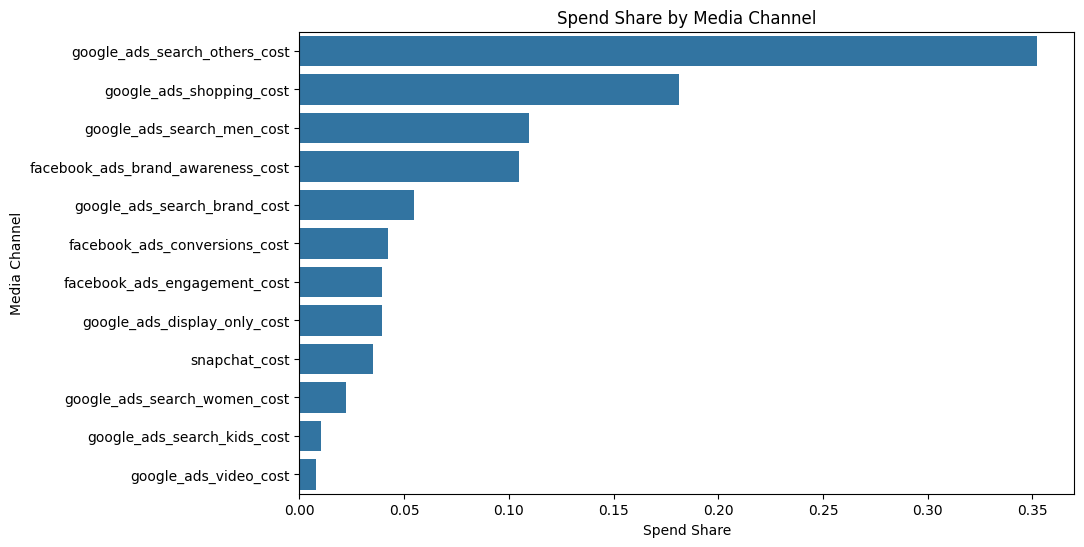


******** Correlation Analysis ********
Using revenue column: ecommerce_revenue
Correlation of inputs with ecommerce_revenue:
seasonal_ecommerce_revenue           0.756724
google_ads_search_others_cost        0.616829
google_ads_search_women_cost         0.547161
google_ads_search_men_cost           0.386566
google_ads_search_brand_cost         0.278506
facebook_ads_conversions_cost        0.276090
google_ads_shopping_cost             0.243106
google_ads_search_kids_cost          0.163661
facebook_ads_engagement_cost         0.139052
t                                   -0.028162
events                              -0.065149
google_ads_video_cost               -0.084232
google_ads_display_only_cost        -0.087559
snapchat_cost                       -0.099610
youtube_organic_views               -0.105094
emails_delivered                    -0.118427
facebook_ads_brand_awareness_cost   -0.122690
population                                NaN
Name: ecommerce_revenue, dtype: float64


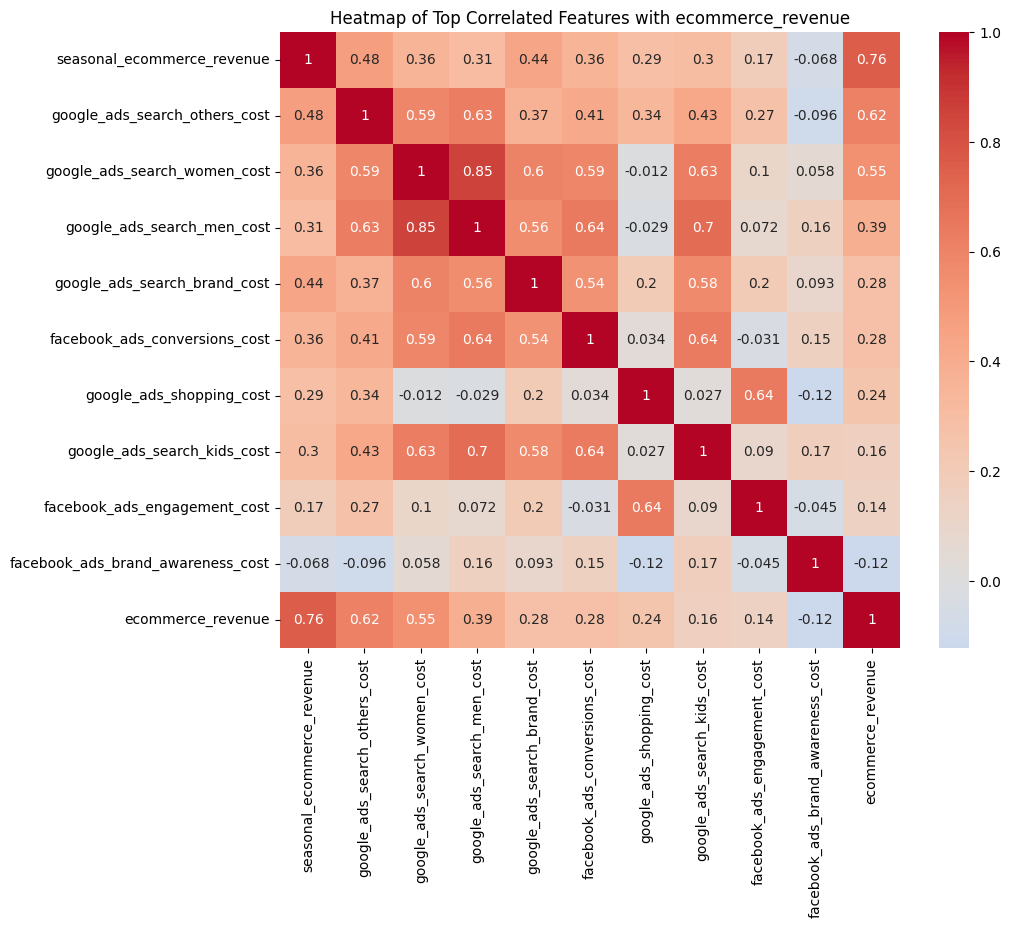


******** Multicollinearity Analysis ********
                              Feature        VIF
7          google_ads_search_men_cost  13.536219
15                                  t  10.330483
11       google_ads_search_women_cost   9.308987
10       google_ads_search_brand_cost   6.654955
12      google_ads_search_others_cost   5.828347
8         google_ads_search_kids_cost   5.741159
2       facebook_ads_conversions_cost   4.631049
0                       snapchat_cost   3.196262
6            google_ads_shopping_cost   3.129415
4        facebook_ads_engagement_cost   1.988359
3   facebook_ads_brand_awareness_cost   1.693756
14                             events   1.377799
1                    emails_delivered   1.375474
13              youtube_organic_views   1.362403
9        google_ads_display_only_cost   1.118995
5               google_ads_video_cost   1.078077

******** Variables with Less Than 15 Records ********
All variables have at least 15 records.


In [ ]:
# Import necessary libraries for visualization and multicollinearity analysis.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor

# ----------------------------
# 1. Spend Share Analysis
# ----------------------------
print("******** Spend Share Analysis ********")
if media:
    # Calculate total spend across all identified media channels.
    total_media_spend = data[media].sum().sum()
    # Compute spend share for each media channel.
    spend_share = data[media].sum() / total_media_spend
    spend_share_df = spend_share.reset_index()
    spend_share_df.columns = ['Media_Channel', 'Spend_Share']
    print(spend_share_df)

    # Plot a bar chart of spend share.
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Spend_Share', y='Media_Channel',
                data=spend_share_df.sort_values(by='Spend_Share', ascending=False))
    plt.title("Spend Share by Media Channel")
    plt.xlabel("Spend Share")
    plt.ylabel("Media Channel")
    plt.show()
else:
    print("No media channels available for spend share analysis.")


# ----------------------------
# 2. Correlation Analysis between Inputs and Output (ecommerce_revenue)
# ----------------------------
print("\n******** Correlation Analysis ********")
# Determine the revenue column (assume that output[0] is the revenue column, as set previously)
revenue_col = output[0] if output and output[0] in data.columns else 'ecommerce_revenue'
print("Using revenue column:", revenue_col)

# Select only numeric features from the complete dataset.
numeric_data = data.select_dtypes(include=[np.number])
corr_matrix = numeric_data.corr()

if revenue_col in corr_matrix.columns:
    # Calculate correlation of all numeric features with the revenue column.
    corr_with_rev = corr_matrix[revenue_col].drop(labels=[revenue_col]).sort_values(ascending=False)
    print("Correlation of inputs with {}:".format(revenue_col))
    print(corr_with_rev)

    # Identify top 10 features most correlated (by absolute value) with the revenue.
    top_features = corr_with_rev.abs().sort_values(ascending=False).head(10).index.tolist() + [revenue_col]

    # Plot a heatmap displaying correlations among these top features.
    plt.figure(figsize=(10, 8))
    sns.heatmap(numeric_data[top_features].corr(), annot=True, cmap='coolwarm', center=0)
    plt.title("Heatmap of Top Correlated Features with {}".format(revenue_col))
    plt.show()
else:
    print("Revenue column not found in the correlation matrix.")


# ----------------------------
# 3. Multicollinearity Analysis (Variance Inflation Factor)
# ----------------------------
print("\n******** Multicollinearity Analysis ********")
# Use the feature set X defined earlier; select only numeric columns.
X_numeric = X.select_dtypes(include=[np.number])
if not X_numeric.empty:
    vif_df = pd.DataFrame()
    vif_df["Feature"] = X_numeric.columns
    # Calculate VIF for each feature.
    vif_df["VIF"] = [variance_inflation_factor(X_numeric.values, i)
                     for i in range(X_numeric.shape[1])]
    print(vif_df.sort_values(by="VIF", ascending=False))
else:
    print("No numeric features available in X for multicollinearity analysis.")


# ----------------------------
# 4. Check for Variables with Less Than 15 Records
# ----------------------------
print("\n******** Variables with Less Than 15 Records ********")
low_record_columns = {col: data[col].count() for col in data.columns if data[col].count() < 15}
if low_record_columns:
    for col, cnt in low_record_columns.items():
        print(f"Column '{col}' has only {cnt} recorded non-null entries.")
else:
    print("All variables have at least 15 records.")


In [ ]:
def create_channel_mappings(media, impressions):
    """
    Generate mapping dictionaries for media spend and impressions columns.

    Parameters:
        media (list of str): List of column names with spend/cost data.
                             Expected to have columns ending with '_cost'.
        impressions (list of str): List of column names with impressions data.
                                   Expected to have columns ending with '_cost_impressions'.

    Returns:
        tuple: Two dictionaries:
            - correct_media_spend_to_channel: Mapping of cost column names to simplified channel names.
            - correct_media_to_channel: Mapping of impressions column names to simplified channel names.
    """
    correct_media_spend_to_channel = {}
    for col in media:
        if col.endswith("_cost"):
            channel_name = col[:-len("_cost")]
        else:
            channel_name = col
        correct_media_spend_to_channel[col] = channel_name

    correct_media_to_channel = {}
    for col in impressions:
        if col.endswith("_impressions"):
          #substitute
            channel_name = col[:-len("_impressions")]
        else:
            channel_name = col
        correct_media_to_channel[col] = channel_name

    return correct_media_spend_to_channel, correct_media_to_channel



cost_mapping, impressions_mapping = create_channel_mappings(media, media)
print("Cost Mapping:", cost_mapping)
print("Impressions Mapping:", impressions_mapping)

Cost Mapping: {'snapchat_cost': 'snapchat', 'facebook_ads_conversions_cost': 'facebook_ads_conversions', 'facebook_ads_brand_awareness_cost': 'facebook_ads_brand_awareness', 'facebook_ads_engagement_cost': 'facebook_ads_engagement', 'google_ads_video_cost': 'google_ads_video', 'google_ads_shopping_cost': 'google_ads_shopping', 'google_ads_search_men_cost': 'google_ads_search_men', 'google_ads_search_kids_cost': 'google_ads_search_kids', 'google_ads_display_only_cost': 'google_ads_display_only', 'google_ads_search_brand_cost': 'google_ads_search_brand', 'google_ads_search_women_cost': 'google_ads_search_women', 'google_ads_search_others_cost': 'google_ads_search_others'}
Impressions Mapping: {'snapchat_cost': 'snapchat_cost', 'facebook_ads_conversions_cost': 'facebook_ads_conversions_cost', 'facebook_ads_brand_awareness_cost': 'facebook_ads_brand_awareness_cost', 'facebook_ads_engagement_cost': 'facebook_ads_engagement_cost', 'google_ads_video_cost': 'google_ads_video_cost', 'google_ads

In [ ]:
def create_seasonality_features(data: pd.DataFrame, date_column: str, output_variable: str, yearly_seasonality: int) -> pd.DataFrame:
    """
    Creates seasonality effect features for modeling based on the yearly seasonality using the statsmodels library.

    Parameters:
    - data (pd.DataFrame): The input dataframe.
    - date_column (str): The name of the date column.
    - output_variable (str): The name of the output variable.
    - yearly_seasonality (int): The yearly seasonality period (e.g., 52 for weekly, 365 for daily).

    Returns:
    - pd.DataFrame: The dataframe with added seasonality features.
    """
    from statsmodels.tsa.seasonal import seasonal_decompose

    # Ensure the date column is in datetime format
    data[date_column] = pd.to_datetime(data[date_column])

    # Sort the data by date
    data = data.sort_values(by=date_column)

    # Set the date column as index for seasonal decomposition
    data.set_index(date_column, inplace=True)

    # Perform seasonal decomposition with multiplicative model
    decomposition = seasonal_decompose(data[output_variable], model='multiplicative', period=yearly_seasonality)

    # Add seasonal component as a feature
    data[f'seasonal_{output_variable}'] = decomposition.seasonal

    # Reset index to retain the date column
    data.reset_index(inplace=True)

    return data

# Example usage
data = create_seasonality_features(
    data,
    date_column='date_week',
    output_variable='ecommerce_revenue',
    yearly_seasonality=52
)

data.head()

,date_week,ecommerce_revenue,snapchat_cost,emails_delivered,facebook_ads_conversions_cost,facebook_ads_brand_awareness_cost,facebook_ads_engagement_cost,google_ads_video_cost,google_ads_shopping_cost,google_ads_search_men_cost,...,google_ads_display_only_cost,google_ads_search_brand_cost,google_ads_search_women_cost,google_ads_search_others_cost,youtube_organic_views,events,t,seasonal_ecommerce_revenue,geo,population
0,2020-12-28,28104.10,0.0,0,0.0,0.0,0.0,0.0,73.27,0.0,...,696.29,0.0,0.0,754.17,3017,0,0,0.467648,national_geo,1.0
1,2021-01-04,228256.30,0.0,0,0.0,0.0,0.0,0.0,263.44,0.0,...,878.88,0.0,0.0,1923.21,6743,0,1,1.673583,national_geo,1.0
2,2021-01-11,134099.64,0.0,0,0.0,0.0,0.0,0.0,216.52,0.0,...,117.19,0.0,0.0,1763.01,5145,0,2,1.275803,national_geo,1.0
3,2021-01-18,97127.95,0.0,0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.00,0.0,0.0,1409.80,6587,0,3,2.267337,national_geo,1.0
4,2021-01-25,80979.20,0.0,0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.00,0.0,0.0,1043.07,6838,0,4,1.817612,national_geo,1.0


In [ ]:
# Fix the mismatch in controls by renaming 'events' => 'events_events'
# (or whichever naming scheme you prefer if you actually want it to be 'events')

coord_to_columns = load.CoordToColumns(
    time='date_week',
    kpi='ecommerce_revenue',   # make sure this matches your KPI column in the DataFrame
    controls=['events', 'seasonal_ecommerce_revenue'],  # corrected name
    media=media,
    media_spend=media,
    organic_media=['emails_delivered'],  # or whichever email column you truly nee
)

loader = load.DataFrameDataLoader(
    df=data,
    kpi_type='revenue',
    coord_to_columns=coord_to_columns,
    media_to_channel=cost_mapping,
    media_spend_to_channel=cost_mapping,
)
data_meridian = loader.load()

/Users/gabriele/Documents/meridian/meridian/data/load.py:887: UserWarning: The `population` argument is ignored in a nationally aggregated model. It will be reset to [1, 1, ..., 1]
  warnings.warn(
/Users/gabriele/Documents/meridian/meridian/data/load.py:1020: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  self.df[geo_column_name] = self.df[geo_column_name].replace(
/Users/gabriele/Documents/meridian/meridian/data/load.py:201: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if (constants.GEO) not in self.dataset.dims.keys():
/Users/gabriele/Documents/meridian/mer

In [ ]:
data_meridian.as_dataset()

<xarray.Dataset> Size: 41kB
Dimensions:                (time: 161, geo: 1, control_variable: 2,
                            media_time: 161, media_channel: 12,
                            organic_media_channel: 1)
Coordinates:
  * time                   (time) object 1kB '2020-12-28' ... '2024-01-22'
  * geo                    (geo) <U12 48B 'national_geo'
  * control_variable       (control_variable) object 16B 'events' 'seasonal_e...
  * media_time             (media_time) object 1kB '2020-12-28' ... '2024-01-22'
  * media_channel          (media_channel) <U28 1kB 'snapchat' ... 'google_ad...
  * organic_media_channel  (organic_media_channel) object 8B 'emails_delivered'
Data variables:
    kpi                    (geo, time) float64 1kB 2.81e+04 ... 2.028e+05
    controls               (geo, time, control_variable) float64 3kB 0.0 ... ...
    population             (geo) float64 8B 1.0
    revenue_per_kpi        (geo, time) float64 1kB 1.0 1.0 1.0 ... 1.0 1.0 1.0
    media                  (geo, media_time, media_channel) float64 15kB 0.0 ...
    media_spend            (geo, time, media_channel) float64 15kB 0.0 ... 2....
    organic_media          (geo, media_time, organic_media_channel) int64 1kB ...

In [ ]:
#functiom to translate the media ROI into a log normal distribution usable by the model prios

def estimate_lognormal_dist(mean, std):
    """
    Reparameterizes the LogNormal distribution in terms of its mean and std.
    Returns mu_log and std_log which can be used to define a LogNormal.
    """
    mu_log = np.log(mean) - 0.5 * np.log((std/mean)**2 + 1)
    std_log = np.sqrt(np.log((std/mean)**2 + 1))
    return mu_log, std_log

roi_mu= 5
roi_sigma= 4.5

roi_mu_log, roi_sigma_log=estimate_lognormal_dist(roi_mu, roi_sigma)
print(roi_mu_log, roi_sigma_log)
"""
# setting priors based on spend share
total_spend= data[media].sum().sum()
priors={'mu':[], 'sigma':[]}
for i in media:
  spend_share=(data[i].sum()/total_spend)*2
  roi_sigma=roi_mu*spend_share
  mu , sigma= estimate_lognormal_dist(roi_mu, roi_sigma)
  priors['mu'].append(mu)
  priors['sigma'].append(sigma)

print(priors)

roi_mu=priors['mu']
roi_sigma=priors['sigma']
print(roi_mu)"""


1.3127744897952331 0.7702771223902047


"\n# setting priors based on spend share\ntotal_spend= data[media].sum().sum()\npriors={'mu':[], 'sigma':[]}\nfor i in media:\n  spend_share=(data[i].sum()/total_spend)*2\n  roi_sigma=roi_mu*spend_share\n  mu , sigma= estimate_lognormal_dist(roi_mu, roi_sigma)\n  priors['mu'].append(mu)\n  priors['sigma'].append(sigma)\n\nprint(priors)\n\nroi_mu=priors['mu']\nroi_sigma=priors['sigma']\nprint(roi_mu)"

In [ ]:
prior = prior_distribution.PriorDistribution(
    roi_m=tfp.distributions.LogNormal(1.31277, 0.770, name=constants.ROI_M)
)
model_spec = spec.ModelSpec(prior=prior)
mmm = model.Meridian(input_data=data_meridian, model_spec=model_spec)
mmm.sample_prior(500)  # Should now work without dtype mismatch

/Users/gabriele/Documents/meridian/meridian/model/model.py:67: UserWarning: In a nationally aggregated model, the `media_effects_dist` will be reset to `normal`.
  warnings.warn(
/Users/gabriele/Documents/meridian/meridian/model/prior_distribution.py:846: UserWarning: Hierarchical distribution parameters must be deterministically zero for national models. tau_g_excl_baseline has been automatically set to Deterministic(0).
  warnings.warn(
/Users/gabriele/Documents/meridian/meridian/model/prior_distribution.py:846: UserWarning: Hierarchical distribution parameters must be deterministically zero for national models. eta_m has been automatically set to Deterministic(0).
  warnings.warn(
/Users/gabriele/Documents/meridian/meridian/model/prior_distribution.py:846: UserWarning: Hierarchical distribution parameters must be deterministically zero for national models. eta_rf has been automatically set to Deterministic(0).
  warnings.warn(
/Users/gabriele/Documents/meridian/meridian/model/prior_

In [ ]:
from tqdm import tqdm
mmm = model.Meridian(input_data=data_meridian, model_spec=model_spec)
mmm.sample_prior(500)  # Should now work without dtype mismatch
with tqdm(total=5*1000, desc="Training Progress") as pbar:  # Total iterations
    def update_progress(current_iteration, total_iterations):
        pbar.update(current_iteration)  # Update the progress bar


    # Remove progress_callback from the sample_posterior call
    mmm.sample_posterior(
        n_chains=7,
        n_adapt=500,
        n_burnin=500,
        n_keep=1000,
        #parallel_iterations=10,
        #progress_callback=update_progress  # Remove this line
    )
    # Manually update progress bar after sampling
    pbar.update(5 * 1000)


model_diagnostics = visualizer.ModelDiagnostics(mmm)
model_diagnostics.predictive_accuracy_table()


/Users/gabriele/Documents/meridian/meridian/model/model.py:67: UserWarning: In a nationally aggregated model, the `media_effects_dist` will be reset to `normal`.
  warnings.warn(
/Users/gabriele/Documents/meridian/meridian/model/prior_distribution.py:846: UserWarning: Hierarchical distribution parameters must be deterministically zero for national models. tau_g_excl_baseline has been automatically set to Deterministic(0).
  warnings.warn(
/Users/gabriele/Documents/meridian/meridian/model/prior_distribution.py:846: UserWarning: Hierarchical distribution parameters must be deterministically zero for national models. eta_m has been automatically set to Deterministic(0).
  warnings.warn(
/Users/gabriele/Documents/meridian/meridian/model/prior_distribution.py:846: UserWarning: Hierarchical distribution parameters must be deterministically zero for national models. eta_rf has been automatically set to Deterministic(0).
  warnings.warn(
/Users/gabriele/Documents/meridian/meridian/model/prior_

W0000 00:00:1739723249.886908 6467093 assert_op.cc:38] Ignoring Assert operator mcmc_retry_init/assert_equal_1/Assert/AssertGuard/Assert


/Users/gabriele/miniforge3/envs/pymc/lib/python3.12/site-packages/arviz/data/inference_data.py:157: UserWarning: trace group is not defined in the InferenceData scheme
  warnings.warn(
/Users/gabriele/miniforge3/envs/pymc/lib/python3.12/site-packages/arviz/data/inference_data.py:1655: UserWarning: trace group is not defined in the InferenceData scheme
  warnings.warn(
Training Progress: 100%|██████████| 5000/5000 [01:58<00:00, 42.26it/s]
/Users/gabriele/Documents/meridian/meridian/analysis/analyzer.py:182: UserWarning: The `aggregate_geos` argument is ignored in the national model. It will be reset to `True`.
  warnings.warn(


,metric,geo_granularity,value
0,R_Squared,national,0.602487
1,MAPE,national,0.314553
2,wMAPE,national,0.274973


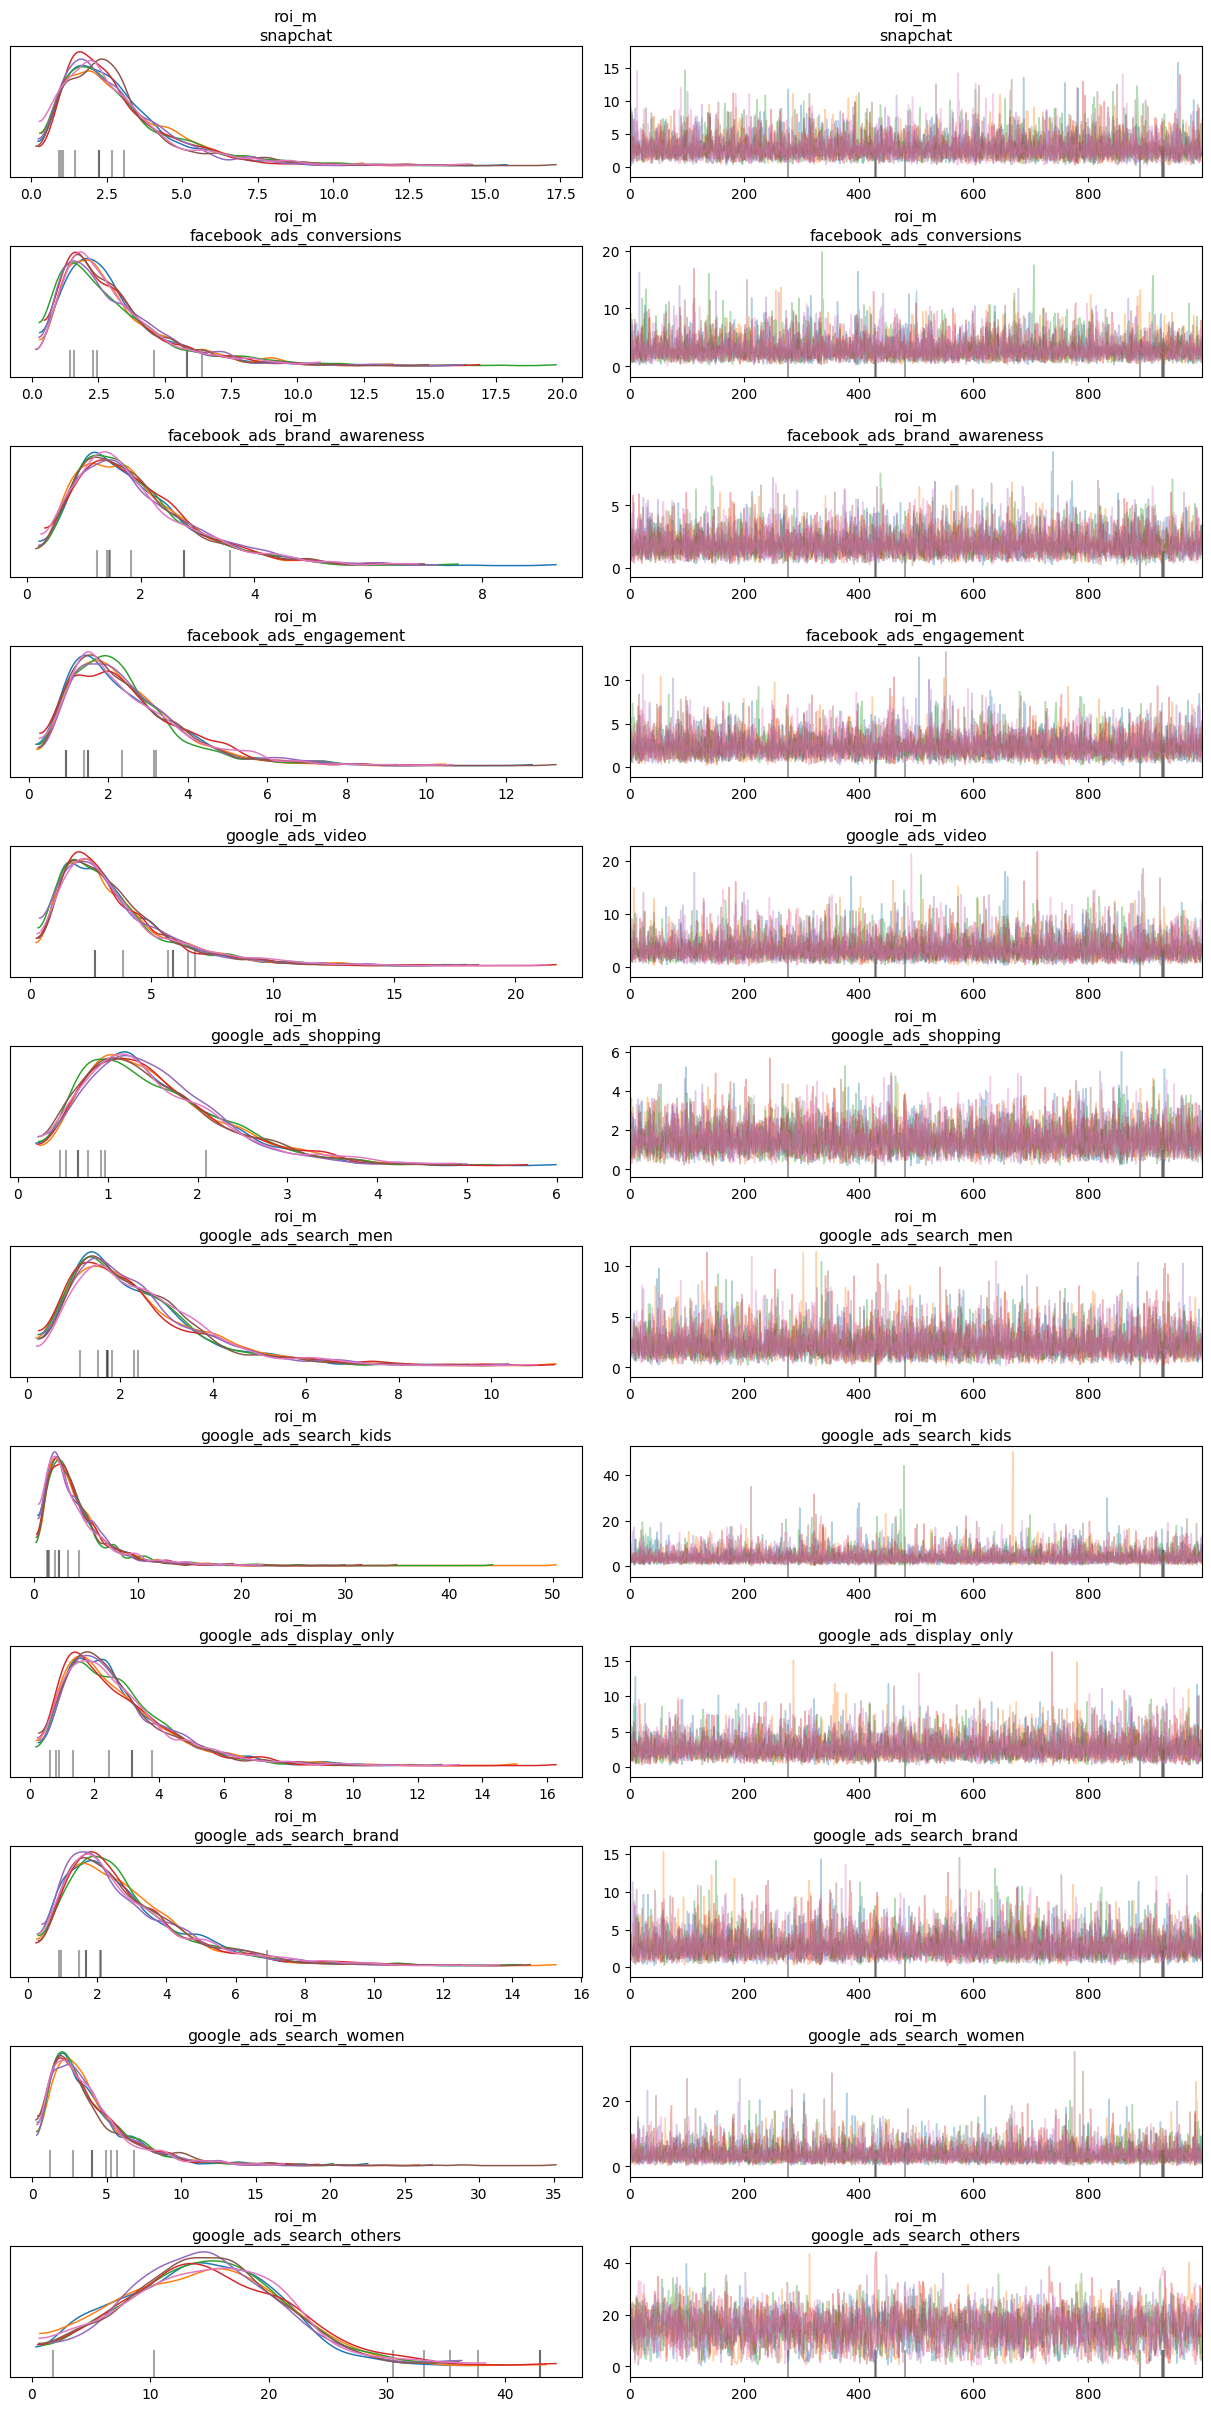

In [ ]:
parameters_to_plot=["roi_m"]
for params in parameters_to_plot:
  az.plot_trace(
      mmm.inference_data,
      var_names=params,
      compact=False,
      backend_kwargs={"constrained_layout": True},
  )


In [ ]:
model_diagnostics = visualizer.ModelDiagnostics(mmm)
model_diagnostics.plot_rhat_boxplot()

alt.LayerChart(...)

In [ ]:
model_fit = visualizer.ModelFit(mmm)
model_fit.plot_model_fit()


/Users/gabriele/Documents/meridian/meridian/analysis/analyzer.py:182: UserWarning: The `aggregate_geos` argument is ignored in the national model. It will be reset to `True`.
  warnings.warn(


alt.LayerChart(...)

In [ ]:
media_summary = visualizer.MediaSummary(mmm)
media_summary.summary_table()


/Users/gabriele/Documents/meridian/meridian/analysis/analyzer.py:533: UserWarning: Setting `use_kpi=True` has no effect when `kpi_type=REVENUE` since in this case, KPI is equal to revenue.
  warnings.warn(
/Users/gabriele/miniforge3/envs/pymc/lib/python3.12/site-packages/tensorflow/python/autograph/impl/api.py:371: UserWarning: Setting `use_kpi=True` has no effect when `kpi_type=REVENUE` since in this case, KPI is equal to revenue.
  return py_builtins.overload_of(f)(*args)
/Users/gabriele/Documents/meridian/meridian/analysis/visualizer.py:1540: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  .aggregate(lambda g: f'{g[0]} ({g[1]}, {g[2]})')


,channel,distribution,impressions,% impressions,spend,% spend,cpm,incremental outcome,% contribution,roi,effectiveness,mroi,cpik
0,snapchat,prior,"28,196",3.5%,"$28,196",3.5%,"$1,000","$151,605 ($32,579, $440,410)","0.8% (0.2%, 2.3%)","5.4 (1.2, 15.6)","5.38 (1.16, 15.62)","2.7 (0.5, 8.3)","$0.3 ($0.1, $0.9)"
1,snapchat,posterior,"28,196",3.5%,"$28,196",3.5%,"$1,000","$80,800 ($22,153, $184,417)","0.7% (0.2%, 1.6%)","2.9 (0.8, 6.5)","2.87 (0.79, 6.54)","1.4 (0.3, 3.5)","$0.4 ($0.2, $1.3)"
2,facebook_ads_conversions,prior,"34,051",4.2%,"$34,051",4.2%,"$1,000","$171,543 ($34,329, $444,726)","0.9% (0.2%, 2.4%)","5.0 (1.0, 13.1)","5.04 (1.01, 13.06)","2.4 (0.4, 6.7)","$0.3 ($0.1, $1.0)"
3,facebook_ads_conversions,posterior,"34,051",4.2%,"$34,051",4.2%,"$1,000","$103,786 ($28,327, $243,190)","0.9% (0.3%, 2.2%)","3.0 (0.8, 7.1)","3.05 (0.83, 7.14)","1.5 (0.3, 3.7)","$0.4 ($0.1, $1.2)"
4,facebook_ads_brand_awareness,prior,"84,544",10.5%,"$84,544",10.5%,"$1,000","$407,553 ($80,797, $1,112,180)","2.2% (0.4%, 5.9%)","4.8 (1.0, 13.2)","4.82 (0.96, 13.16)","1.8 (0.3, 5.0)","$0.3 ($0.1, $1.0)"
5,facebook_ads_brand_awareness,posterior,"84,544",10.5%,"$84,544",10.5%,"$1,000","$162,239 ($52,206, $341,012)","1.4% (0.5%, 3.0%)","1.9 (0.6, 4.0)","1.92 (0.62, 4.03)","0.7 (0.2, 1.5)","$0.6 ($0.2, $1.6)"
6,facebook_ads_engagement,prior,"31,932",4.0%,"$31,932",4.0%,"$1,000","$167,469 ($36,671, $466,939)","0.9% (0.2%, 2.5%)","5.2 (1.1, 14.6)","5.24 (1.15, 14.62)","1.8 (0.4, 5.1)","$0.3 ($0.1, $0.9)"
7,facebook_ads_engagement,posterior,"31,932",4.0%,"$31,932",4.0%,"$1,000","$78,016 ($24,435, $165,251)","0.7% (0.2%, 1.5%)","2.4 (0.8, 5.2)","2.44 (0.77, 5.18)","0.9 (0.2, 1.9)","$0.5 ($0.2, $1.3)"
8,google_ads_video,prior,"6,514",0.8%,"$6,514",0.8%,"$1,000","$33,917 ($6,855, $90,908)","0.2% (0.0%, 0.5%)","5.2 (1.1, 14.0)","5.21 (1.05, 13.95)","3.4 (0.6, 9.4)","$0.3 ($0.1, $1.0)"
9,google_ads_video,posterior,"6,514",0.8%,"$6,514",0.8%,"$1,000","$22,563 ($6,019, $52,580)","0.2% (0.1%, 0.5%)","3.5 (0.9, 8.1)","3.46 (0.92, 8.07)","2.3 (0.5, 5.7)","$0.3 ($0.1, $1.1)"


In [ ]:

# Generate each individual chart and remove their individual config attributes to avoid conflicts on concatenation
media_summary.plot_contribution_waterfall_chart()


alt.LayerChart(...)

In [ ]:
media_summary.plot_contribution_pie_chart()


alt.LayerChart(...)

In [ ]:
media_summary.plot_spend_vs_contribution()


alt.FacetChart(...)

In [ ]:
media_summary.plot_roi_bar_chart()


alt.LayerChart(...)

In [ ]:
media_summary.plot_roi_vs_effectiveness()


alt.Chart(...)

In [ ]:
media_summary.plot_roi_vs_mroi()


alt.Chart(...)

In [ ]:
media_effects = visualizer.MediaEffects(mmm)
media_effects.plot_response_curves()

alt.FacetChart(...)

In [ ]:
media_effects.plot_adstock_decay()


alt.FacetChart(...)

In [ ]:
# Get last 4 weeks of data
last_4_weeks = data['date_week'][-4:].values

print("Last 4 weeks:")
for week in last_4_weeks:
    print(week)

# Calculate total media spend in last 4 weeks
last_4_weeks_spend = data[media].iloc[-4:]

print("\nTotal media spend in last 4 weeks:")
for week, spend in zip(last_4_weeks, last_4_weeks_spend):
    print(week,spend)

print(last_4_weeks_spend.sum().sum())

print(len(media))

Last 4 weeks:
2024-01-01T00:00:00.000000000
2024-01-08T00:00:00.000000000
2024-01-15T00:00:00.000000000
2024-01-22T00:00:00.000000000

Total media spend in last 4 weeks:
2024-01-01T00:00:00.000000000 criteo_cost
2024-01-08T00:00:00.000000000 facebook_ads_conversions_cost
2024-01-15T00:00:00.000000000 facebook_ads_brand_awareness_cost
2024-01-22T00:00:00.000000000 facebook_ads_performance_engagement_cost
32733.39
12


In [ ]:
data


budget_optimizer = optimizer.BudgetOptimizer(mmm)
optimization_results = budget_optimizer.optimize(
      selected_times=('2024-01-01', '2024-01-22'),
      budget=32733,
      spend_constraint_lower=[0.3, 0.2, 0.3, 0.3, 0.3, 0.2, 0.3, 0.2, 0.3, 0.3, 0.3, 0.2],
      spend_constraint_upper=[0.3, 0.2, 0.3, 0.3, 0.3, 0.2, 0.3, 0.2, 0.3, 0.3, 0.3, 0.2],
)

/Users/gabriele/Documents/meridian/meridian/analysis/optimizer.py:1003: RuntimeWarning: invalid value encountered in divide
  spend_ratio = spend / hist_spend


In [ ]:
optimization_results.nonoptimized_data

<xarray.Dataset> Size: 4kB
Dimensions:              (channel: 12, metric: 4)
Coordinates:
  * channel              (channel) <U35 2kB 'criteo' ... 'google_ads_search_o...
  * metric               (metric) <U6 96B 'mean' 'median' 'ci_lo' 'ci_hi'
Data variables:
    spend                (channel) float32 48B 0.0 2.06e+03 ... 1.447e+04
    pct_of_spend         (channel) float32 48B 0.0 0.06292 ... 0.08949 0.442
    incremental_outcome  (channel, metric) float64 384B 0.0 0.0 ... 2.677e+05
    pct_of_contribution  (channel, metric) float64 384B 0.0 0.0 ... 8.089 51.15
    effectiveness        (channel, metric) float64 384B nan nan ... 2.924 18.49
    roi                  (channel, metric) float64 384B 0.0 0.0 ... 2.925 18.5
    mroi                 (channel, metric) float64 384B 0.0 0.0 ... 0.9611 8.576
    cpik                 (channel, metric) float64 384B 0.0 0.0 ... 0.3419
Attributes:
    start_date:                 2024-01-01
    end_date:                   2024-01-22
    budget:                     32740.0
    profit:                     152633.29345703125
    total_incremental_outcome:  185373.29345703125
    total_roi:                  5.661982084820747
    total_cpik:                 0.21265988
    is_revenue_kpi:             True
    confidence_level:           0.9
    use_historical_budget:      True

In [ ]:
optimization_results.optimized_data


<xarray.Dataset> Size: 4kB
Dimensions:              (channel: 12, metric: 4)
Coordinates:
  * channel              (channel) <U35 2kB 'criteo' ... 'google_ads_search_o...
  * metric               (metric) <U6 96B 'mean' 'median' 'ci_lo' 'ci_hi'
Data variables:
    spend                (channel) float32 48B 0.0 2.45e+03 ... 1.736e+04
    pct_of_spend         (channel) float32 48B 0.0 0.07483 ... 0.06261 0.5302
    incremental_outcome  (channel, metric) float64 384B 0.0 0.0 ... 2.881e+05
    pct_of_contribution  (channel, metric) float64 384B 0.0 0.0 ... 8.42 53.82
    effectiveness        (channel, metric) float64 384B nan nan ... 3.114 19.91
    roi                  (channel, metric) float64 384B 0.0 0.0 ... 2.596 16.6
    mroi                 (channel, metric) float64 384B 0.0 0.0 ... 0.747 7.118
    cpik                 (channel, metric) float64 384B 0.0 0.0 ... 0.3852
Attributes:
    start_date:                 2024-01-01
    end_date:                   2024-01-22
    budget:                     32740.0
    profit:                     164636.1278076172
    total_incremental_outcome:  197376.1278076172
    total_roi:                  6.028592785816041
    total_cpik:                 0.20144399
    is_revenue_kpi:             True
    confidence_level:           0.9
    use_historical_budget:      True
    fixed_budget:               True

In [ ]:
budget_optimizer = optimizer.BudgetOptimizer(mmm)
optimization_results = budget_optimizer.optimize()